In [29]:
from datetime import datetime
import hashlib
import os.path
import random
import re
import struct
import sys
import tarfile
from tqdm import tqdm
import time

import numpy as np
from six.moves import urllib
import tensorflow as tf

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def create_image_lists(image_dir, testing_percentage, validation_percentage):
    """이미지 디렉토리에서 인풋 데이터를 찾아 데이터로 변환한다"""
    
    ## image_dir가 존재하지 않는다면 오류 출력
    if not gfile.Exists(image_dir):
        print("Image directory '" + image_dir + "' not found.")
        return None
    
    result = {}
    
    ### image_dir 내 하위 디렉토리(label)를 가져온다 
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)]
    
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue
        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
        
        file_list = []
        dir_name = os.path.basename(sub_dir)
        if dir_name == image_dir:
            continue
            
        print("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
            file_list.extend(gfile.Glob(file_glob))
        
        ## 파일이 없거나 데이터가 작으면 예외 처리
        if not file_list:
            print('No files found')
            continue
        if len(file_list) < 20:
            print("WARNING: Folder has less than 20 images, which may cause issues.")
        elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
            print("WARNING: Folder {} has more than {} images. Some images will never be selected".format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
        
        ## 트레이닝 / 밸리데이션 / 테스트셋으로 나눈다.
        training_images = []
        testing_images = []
        validation_images = []
        for file_name in file_list:
            base_name = os.path.basename(file_name)
            
            hash_name = re.sub(r'_nohash_.*$', '', file_name)
            hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
            percentage_hash = ((int(hash_name_hashed, 16) %
                               (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                              (100.0 / MAX_NUM_IMAGES_PER_CLASS))
            
            if percentage_hash < validation_percentage:
                validation_images.append(base_name)
            elif percentage_hash < (testing_percentage + validation_percentage):
                testing_images.append(base_name)
            else:
                training_images.append(base_name)
        
        result[label_name] = {
            'dir': dir_name,
            'training': training_images,
            'testing': testing_images,
            'validation': validation_images,
        }
        
    return result

In [3]:
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 299
MODEL_INPUT_HEIGHT = 299
MODEL_INPUT_DEPTH = 3
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear:0'
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [5]:
def create_inception_graph():
    """
    저장된 GraphDef 파일에서 그래프를 만들고
    Graph 오브젝트를 리턴한다.
    """
    with tf.Graph().as_default() as graph:
        model_filename = os.path.join(model_dir, 'classify_image_graph_def.pb')
    
        with gfile.FastGFile(model_filename, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (
                tf.import_graph_def(graph_def, name='', return_elements=[
                    BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME, RESIZED_INPUT_TENSOR_NAME]))
    return graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor

In [6]:
def should_distort_images(flip_left_right, random_crop, random_scale, random_brightness):
    """이미지 데이터에 변화를 줄지 결정한다."""
    return (flip_left_right or (random_crop != 0) or (random_scale != 0) or (random_brightness != 0))

In [7]:
def ensure_dir_exists(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [8]:
def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir, category, \
                             bottleneck_dir, jpeg_data_tensor, bottleneck_tensor):
    label_lists = image_lists[label_name]
    sub_dir = label_lists['dir']
    sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
    ensure_dir_exists(sub_dir_path)
    bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                    bottleneck_dir, category)
    if not os.path.exists(bottleneck_path):
        create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                               image_dir, category, sess, jpeg_data_tensor,
                               bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
        bottleneck_string = bottleneck_file.read()
    
    did_hit_error = False
    try:
        bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
    except ValueError:
        print('Invalid float found, recreating bottleneck')
        did_hit_error = True
    if did_hit_error:
        create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                               image_dir, category, sess, jpeg_data_tensor,
                               bottleneck_tensor)
        with open(bottleneck_path, 'r') as bottleneck_file:
            bottleneck_string = bottleneck_file.read()
        # Allow exceptions to propagate here, since they shouldn't happen after a
        # fresh creation
        bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
    return bottleneck_values

In [9]:
def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir, jpeg_data_tensor, bottleneck_tensor):
    how_many_bottlenecks = 0
    ensure_dir_exists(bottleneck_dir)
    for label_name, label_lists in image_lists.items():
        for category in ['training', 'testing', 'validation']:
            category_list = label_lists[category]
            for index, unused_base_name in enumerate(category_list):
                get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir, category, \
                                         bottleneck_dir, jpeg_data_tensor, bottleneck_tensor)
                how_many_bottlenecks += 1
                if how_many_bottlenecks % 100 == 0:
                    print('{} bottleneck files created'.format(how_many_bottlenecks))

In [10]:
def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir, category):
    return get_image_path(image_lists, label_name, index, bottleneck_dir, category) + '.txt'

In [11]:
def get_image_path(image_lists, label_name, index, image_dir, category):
    
    if label_name not in image_lists:
        tf.logging.fatal('Label does not exist %s.', label_name)
    label_lists = image_lists[label_name]
    
    if category not in label_lists:
        tf.logging.fatal('Category does not exist %s.', category)
    category_list = label_lists[category]
    
    if not category_list:
        tf.logging.fatal('Label %s has no images in the category %s.', label_name, category)
        
    mod_index = index % len(category_list)
    base_name = category_list[mod_index]
    sub_dir = label_lists['dir']
    full_path = os.path.join(image_dir, sub_dir, base_name)
    
    return full_path

In [12]:
def create_bottleneck_file(bottleneck_path, image_lists, label_name, index, image_dir,
                          category, sess, jpeg_data_tensor, bottleneck_tensor):
    print('보틀넥 파일 생성 시작 - {}'.format(bottleneck_path))
    image_path = get_image_path(image_lists, label_name, index, image_dir, category)
    
    if not gfile.Exists(image_path):
        tf.logging.fata('File does nto exist %s', image_path)
    image_data = gfile.FastGFile(image_path, 'rb').read()
    
    try:
        bottleneck_values = run_bottleneck_on_image(
            sess, image_data, jpeg_data_tensor, bottleneck_tensor)
    except:
        raise RuntimeError('파일 처리 중 에러 발생: %s' % image_path)
        
    bottleneck_string = ','.join(str(x) for x in bottleneck_values)
    with open(bottleneck_path, 'w') as bottleneck_file:
        bottleneck_file.write(bottleneck_string)

In [13]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor, bottleneck_tensor):
    bottleneck_values = sess.run(
        bottleneck_tensor, {image_data_tensor: image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    return bottleneck_values

In [14]:
def add_final_training_ops(class_count, final_tensor_name, bottleneck_tensor):
    with tf.name_scope('input'):
        bottleneck_input = tf.placeholder_with_default(
            bottleneck_tensor, shape=[None, BOTTLENECK_TENSOR_SIZE],
            name='BottleneckInputPlaceholder')
        
        ground_truth_input = tf.placeholder(tf.float32, [None, class_count], name='GroundTruthInput')
        
    layer_name = 'final_training_ops'
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            initial_value = tf.truncated_normal([BOTTLENECK_TENSOR_SIZE, class_count], stddev=0.01)
            
            layer_weights = tf.Variable(initial_value, name='final_weight')
        
        with tf.name_scope('biases'):
            layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
            
        with tf.name_scope('Wx_plus_b'):
            logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
            
    final_tensor = tf.nn.softmax(logits, name=final_tensor_name)
    
    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
            labels=ground_truth_input, logits=logits)
        with tf.name_scope('total'):
            cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_step = optimizer.minimize(cross_entropy_mean)
        
    return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input, final_tensor)


In [15]:
def add_evaluation_step(result_tensor, ground_truth_tensor):
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            prediction = tf.argmax(result_tensor, 1)
            correct_prediction = tf.equal(
                prediction, tf.argmax(ground_truth_tensor, 1))
        with tf.name_scope('accuracy'):
            evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return evaluation_step, prediction

In [16]:
def get_random_cached_bottlenecks(sess, image_lists, how_many, category, bottleneck_dir, image_dir,
                                 jpeg_data_tensor, bottleneck_tensor):
    class_count = len(image_lists.keys())
    bottlenecks = []
    ground_truths = []
    filenames = []
    if how_many >= 0:
        # 샘플링한 보틀넥을 가져온다.
        for unused_i in range(how_many):
            label_index = random.randrange(class_count)
            label_name = list(image_lists.keys())[label_index]
            image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
            image_name = get_image_path(image_lists, label_name, image_index,
                                      image_dir, category)
            bottleneck = get_or_create_bottleneck(sess, image_lists, label_name,
                                                image_index, image_dir, category,
                                                bottleneck_dir, jpeg_data_tensor,
                                                bottleneck_tensor)
            ground_truth = np.zeros(class_count, dtype=np.float32)
            ground_truth[label_index] = 1.0
            bottlenecks.append(bottleneck)
            ground_truths.append(ground_truth)
            filenames.append(image_name)
    else:
        # 보틀넥을 모두 가져온다.
        for label_index, label_name in enumerate(image_lists.keys()):
            for image_index, image_name in enumerate(image_lists[label_name][category]):
                image_name = get_image_path(image_lists, label_name, image_index,
                                            image_dir, category)
                bottleneck = get_or_create_bottleneck(sess, image_lists, label_name,
                                                      image_index, image_dir, category,
                                                      bottleneck_dir, jpeg_data_tensor,
                                                      bottleneck_tensor)
                ground_truth = np.zeros(class_count, dtype=np.float32)
                ground_truth[label_index] = 1.0
                bottlenecks.append(bottleneck)
                ground_truths.append(ground_truth)
                filenames.append(image_name)
    return bottlenecks, ground_truths, filenames


In [20]:
image_dir = 'D:\\DL_picture_data'
output_graph = '/tmp/output_graph.pb'
output_labels = '/tmp/output_labels.txt'
summaries_dir = '/tmp/retrain_logs'
how_many_training_steps = 300
learning_rate = 0.01
testing_percentage = 10
validation_percentage = 10
eval_step_interval = 10
train_batch_size = 100
test_batch_size = -1
validation_batch_size = 100
print_misclassified_test_images = False
model_dir = '/tmp/imagenet'
bottleneck_dir = '/tmp/bottleneck'
final_tensor_name = 'final_result'
flip_left_right = False
random_crop = 0
random_scale = 0
random_brightness = 0 
log_frequency = 10
log_device_placement = False

In [ ]:
graph, bottleneck_tensor, jpeg_data_tensor, resize_image_tensor = (create_inception_graph())


In [21]:
image_lists = create_image_lists(image_dir, testing_percentage, validation_percentage)


ERROR! Session/line number was not unique in database. History logging moved to new session 362


In [22]:
class_count = len(image_lists.keys())


In [23]:
if class_count == 0:
    print('이미지가 해당 경로에 없습니다: ' + image_dir)
    
elif class_count == 1:
    print('해당 경로에 클래스가 1개만 발견되었습니다: ' + image_dir + ' - 분류를 위해 2개 이상의 클래스가 필요합니다.')
    
else:
    print("클래스가 2개 이상 있습니다. 학습을 시작합니다.")

이미지가 해당 경로에 없습니다: D:\DL_picture_data


In [24]:
do_distort_images = should_distort_images(flip_left_right, random_crop, random_scale, random_brightness)


In [25]:
acc_list = []

with tf.Session(graph=graph) as sess:
    if do_distort_images:
        (distorted_jpeg_data_tensor, distorted_image_tensor) = add_input_distortion(
            flip_left_right, random_crop, random_scale, random_brightness)
    else:
        cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir, jpeg_data_tensor, bottleneck_tensor)
    
    ## 네트워크의 끝에 우리가 원하는 분류 레이어를 붙인다.
    (train_step, cross_entropy, bottleneck_input, 
     ground_truth_input, final_tensor) = add_final_training_ops(len(image_lists.keys()), 
                                                                final_tensor_name, 
                                                                bottleneck_tensor)
        
    ## 정확도 평가를 위한 새로운 오퍼레이션
    evaluation_step, prediction = add_evaluation_step(final_tensor, ground_truth_input)
    
    ## 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(how_many_training_steps):
        
        ## 보틀넥과 정답지를 준비한다.
        if do_distort_images:
            (train_bottlenecks, train_ground_truth) = get_random_distorted_bottlenecks(
                sess, image_lists, train_batch_size, 'training', image_dir, distorted_jpeg_data_tensor,
                distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
        else:
            (train_bottlenecks, train_ground_truth, _) = get_random_cached_bottlenecks(
                sess, image_lists, train_batch_size, 'training', bottleneck_dir, image_dir,
                jpeg_data_tensor, bottleneck_tensor)
        
        
        ## 보틀넥과 정답지를 모델에 집어넣어 학습시킨다.
        _ = sess.run(
            [train_step],
            feed_dict={bottleneck_input: train_bottlenecks,
                      ground_truth_input: train_ground_truth})
    
        ## 특정 구간마다 트레이닝 정확도와 cross entropy 로그, 밸리데이션 정확도를 출력한다.
        is_last_step = (i + 1 == how_many_training_steps)
        if (i % eval_step_interval) == 0 or is_last_step:
            train_accuracy, cross_entropy_value = sess.run(
                [evaluation_step, cross_entropy],
                feed_dict = {bottleneck_input: train_bottlenecks,
                            ground_truth_input: train_ground_truth})
            
            print('%s: Step %d: Train accuracy = %.1f%%'% (datetime.now(), i, train_accuracy * 100))
            print('%s: Step %d: Cross entropy = %f' % (datetime.now(), i, cross_entropy_value))
            
            validation_bottlenecks, validation_ground_truth, _ = (
                get_random_cached_bottlenecks(
                    sess, image_lists, validation_batch_size, 'validation', bottleneck_dir,
                    image_dir, jpeg_data_tensor, bottleneck_tensor))
            
            validation_accuracy = sess.run(
                evaluation_step,
                feed_dict = {bottleneck_input: validation_bottlenecks,
                            ground_truth_input: validation_ground_truth})
            print('%s: Step %d: Validation accuracy = %.1f%% (N=%d)'% (datetime.now(), i,
                                                                       validation_accuracy * 100, 
                                                                       len(validation_bottlenecks)))
            
            ## 시각화를 위해 로그를 한벌 더 저장한다.
            acc_list.append({"epoch": i, "train_accuracy": train_accuracy, "validation_accuracy": validation_accuracy})
    
    ## 테스트셋에 사용할 보틀넥과 정답지를 가져온다.
    test_bottlenecks, test_ground_truth, test_filenames = (
        get_random_cached_bottlenecks(sess, image_lists, test_batch_size, 'testing', bottleneck_dir,
                                     image_dir, jpeg_data_tensor, bottleneck_tensor))
    
    ## 테스트셋 정확도와 예측 분류값을 가져온다.
    test_accuracy, predictions = sess.run(
        [evaluation_step, prediction], 
        feed_dict={bottleneck_input: test_bottlenecks,
                  ground_truth_input: test_ground_truth})
    print('최종 학습 정확도 = %.1f%% (N=%d)' % (test_accuracy * 100, len(test_bottlenecks)))
    
    output_graph_def = graph_util.convert_variables_to_constants(
        sess, graph.as_graph_def(), [final_tensor_name])
    with gfile.FastGFile(output_graph, 'wb') as f:
        f.write(output_graph_def.SerializeToString())
    with gfile.FastGFile(output_labels, 'w') as f:
        f.write('\n'.join(image_lists.keys()) + '\n')

NameError: name 'graph' is not defined

In [26]:
import pandas as pd
acc_df = pd.DataFrame.from_dict(acc_list)
acc_df.set_index('epoch', inplace=True)

KeyError: 'epoch'

TypeError: Empty 'DataFrame': no numeric data to plot

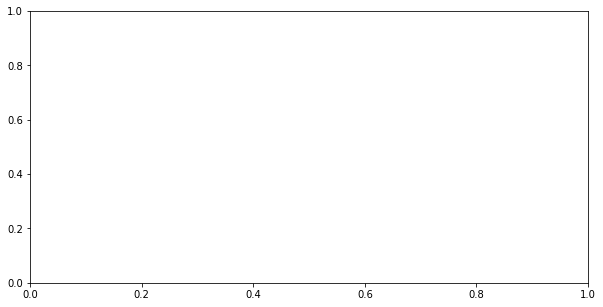